In [2]:
import numpy as np
import torch
import sys
from utils_old import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [4]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
del dataset

In [5]:
n_train = 1300101
path ='./checkpoint1300101/25/'
model = DN(300, 100).cuda()
another_model = another_DN(300, 100).cuda()
model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)

In [6]:
# 看(n_eval,m)
# 选定 X_eval, Y_eval, 还要算phi=Eq[k(y,z)]-Ep[k(x,z)]的threhold在哪里
# 必须手算!
def generate_PQ(n_eval, Samples, batch_size = 10000, If_n_large_MonteCarlo = 1000):
    X_eval = dataset_P[np.random.choice(dataset_P.shape[0], n_eval, replace=False)]
    Y_eval = dataset_Q[np.random.choice(dataset_Q.shape[0], n_eval, replace=False)]
    EKxx, EKyy, EKxy = compute_gamma(X_eval, Y_eval, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, MonteCarlo=If_n_large_MonteCarlo)
    # 算定下来X_eval, Y_eval之后phi的真实的分布
    batches = (Samples-1)//batch_size + 1
    P_scores = np.zeros(Samples)
    Q_scores = np.zeros(Samples)
    for i in trange(batches):
        remain = batch_size
        if i==batches-1:
            remain = Samples - batch_size*(batches-1)
        S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
        S_hand = MatConvert(S_hand, device, dtype)
        PQhat_hand = compute_score_func(S_hand, X_eval, Y_eval, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = n_eval)
        PQhat_hand = PQhat_hand.cpu().detach().numpy()
        P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
        Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
    return X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy


In [7]:
# 注意P_scores, Q_scores已经考虑到n_eval贡献的方差
# EKxx, EKyy, EKxy完全是n_eval决定
class PQ_data():
    def __init__(self, P_scores, Q_scores, EKxx, EKyy, EKxy):
        self.P_scores = P_scores
        self.Q_scores = Q_scores
        self.P_mean = np.mean(P_scores)
        self.P_std = np.std(P_scores)
        self.Q_mean = np.mean(Q_scores)
        self.Q_std = np.std(Q_scores)
        self.EKxx = EKxx
        self.EKyy = EKyy
        self.EKxy = EKxy
    def pval_T_m_in_sigma(self, pi, m, use_gaussian, MonteCarlo):
        T = pi*self.Q_mean + (1-pi)*self.P_mean
        # use_gaussian: 是否用高斯近似, 0是用MonteCarlo近似，1是用高斯近似
        P_scores = self.P_scores
        mean = self.P_mean
        std = self.P_std
        if m==1:
            p = np.mean(P_scores > T)
            p = -scipy.stats.norm.ppf(p)
        if use_gaussian:
            p = (T-mean)/std*np.sqrt(m)
        else:
            T_mix_MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                T_mix_MonteCarlo_list[i] = np.mean(P_scores[idx])
            p = np.mean(T_mix_MonteCarlo_list > T)
            p = -scipy.stats.norm.ppf(p)
        self.p = p
        return p
    def type_1_error_H0(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        mean = self.P_mean
        std = self.P_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        self.gamma = gamma
        if m==1:
            type_1_error = np.mean(P_scores > gamma)
        if use_gaussian:
            type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                MonteCarlo_list[i] = np.mean(P_scores[idx])
            type_1_error = np.mean(MonteCarlo_list > gamma)
        self.type_1_error = type_1_error
        return type_1_error
    def type_2_error_H1(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        Q_std = self.Q_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        self.gamma = gamma
        if m==1:
            type_2_error = np.mean(Q_scores < gamma)
        if use_gaussian:
            mean = Q_mean*pi + P_mean*(1-pi)
            std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2)
            type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
            type_2_error = np.mean(MonteCarlo_list < gamma)
        self.type_2_error = type_2_error
        return type_2_error

In [8]:
torch.cuda.empty_cache()
gc.collect()

0

# 直觉

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


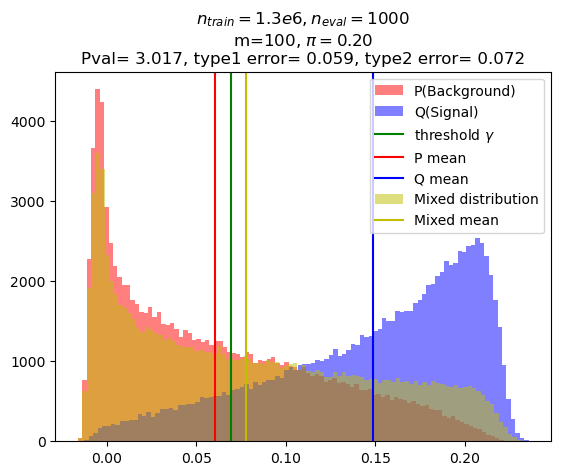

In [9]:
n_eval = 1000
Samples = 100000
X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=100000, batch_size=10000, If_n_large_MonteCarlo = 10)
plt.hist(P_scores, bins=100, alpha=0.5, label='P(Background)', color='r')
plt.hist(Q_scores, bins=100, alpha=0.5, label='Q(Signal)', color='b')
My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
m = 100
pi = 0.2
Pval = My_class.pval_T_m_in_sigma(pi, m, use_gaussian=1, MonteCarlo=0)
Type1 = My_class.type_1_error_H0(pi, m, use_gaussian=1, MonteCarlo=0)
Type2 = My_class.type_2_error_H1(pi, m, use_gaussian=1, MonteCarlo=0)
plt.axvline(My_class.gamma, color='g', label='threshold $\gamma$')
plt.axvline(My_class.P_mean, color='r', label='P mean')
plt.axvline(My_class.Q_mean, color='b', label='Q mean')
title1 = '$n_{train}=1.3e6, n_{eval}=%d$'%n_eval
title2 = 'm=%d, $\pi=%.2f$'%(m, pi)
title3 = 'Pval= %.3f, type1 error= %.3f, type2 error= %.3f'%(Pval, Type1, Type2)
plt.title(title1+'\n'+title2+'\n'+title3)
Mix_scores = np.concatenate((P_scores[0:int(Samples*(1-pi))], Q_scores[0:int(Samples*pi)]))
plt.hist(Mix_scores, bins=100, alpha=0.5, label='Mixed distribution', color='y')
Mix_mean = np.mean(Mix_scores)
plt.axvline(Mix_mean, color='y', label='Mixed mean')
plt.legend()

# 固定pi=0.1, Gaussian
所以对每一组(n,m,pi)有三个(p-val, typeI, typeII)  
pval = pval(平均H1) = 平均H1后面的尾  
type-I = gamma后面  

In [10]:
pi= 0.1
n_list = np.array([2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])

n_list = 10**np.linspace(0.5, 4.3, 40)
n_list = n_list.astype(int)
m_list = 10**np.linspace(0.5, 4.3, 40)
m_list = m_list.astype(int)

repeat_sample_n_eval = 1000
Pval_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_eval))
Type1_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_eval))
Type2_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_eval))
Use_Gaussian = 1

In [11]:
for r in range(repeat_sample_n_eval):
    print(r)
    for i in trange(len(n_list)):
        with torch.no_grad():
            torch.cuda.empty_cache()
            n_eval = n_list[i]
            X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=20000, batch_size=4000, If_n_large_MonteCarlo=10)
            My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
            for j in range(len(m_list)):
                m = m_list[j]
                Pval_mat[i,j,r] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
                Type1_mat[i,j,r] += My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
                Type2_mat[i,j,r] += My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
            del My_class, X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy
            gc.collect()
    clear_output()


55


 42%|████▎     | 17/40 [01:17<01:44,  4.56s/it]

In [ ]:
Type2_mat.shape

(40, 40, 100)

In [ ]:
# np.save('Type1_mat_new_new_new_new.npy',Type1_mat)
# np.save('Type2_mat_new_new_new_new.npy',Type2_mat)
# # Type1_mat = np.load('Type1_mat_new_new_new.npy')
# # Type2_mat = np.load('Type2_mat_new_new_new.npy')

In [ ]:
Type1_mat.shape

(10, 11)

In [ ]:
Type1_mat  = np.mean(Type1_mat[:,:,:], axis=2)
Type2_mat  = np.mean(Type2_mat[:,:,:], axis=2)

In [ ]:
# np.save('Pval_mat_new.npy', Pval_mat)
# np.save('Type1+2_mat.npy', Type1_mat+Type2_mat)
Type1_mat.shape

(40, 40)

Text(0.5, 0.98, 'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx=1, $\\pi$=0.1')

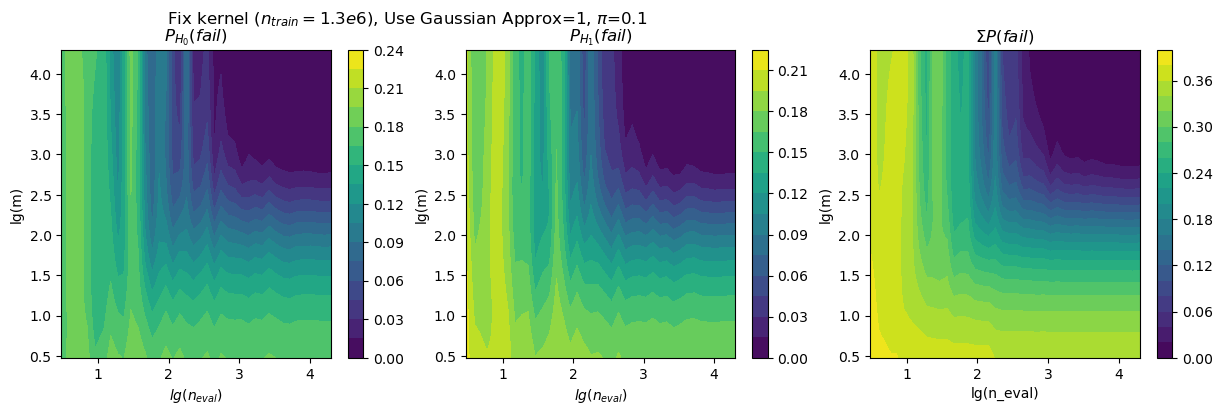

In [ ]:
plt.figure(figsize=(20,4))
# plt.subplot(1,4,1)
# plt.contourf(np.log10(n_list), np.log10(m_list), Pval_mat.T, levels=20)
# plt.colorbar()
# plt.xlabel('$lg(n_{eval})$')
# plt.ylabel('lg(m)')
# plt.title('p-value')

plt.subplot(1,4,2)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_0}(fail)$')

plt.subplot(1,4,3)
plt.contourf(np.log10(n_list), np.log10(m_list), Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_1}(fail)$')

plt.subplot(1,4,4)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T+Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('lg(n_eval)')
plt.ylabel('lg(m)')
plt.title('$\Sigma P(fail)$')

plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))

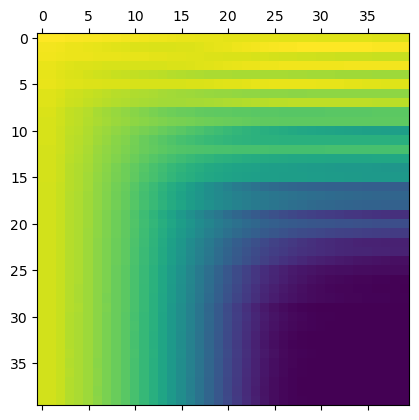

In [ ]:
type123 = Type1_mat+Type2_mat
plt.matshow(type123)

# 固定pi=0.1, 不Gaussian

In [ ]:
pi= 0.1
n_list = np.array([2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
Pval_mat = np.zeros((len(n_list), len(m_list)))
Type1_mat = np.zeros((len(n_list), len(m_list)))
Type2_mat = np.zeros((len(n_list), len(m_list)))
Use_Gaussian = 0
MonteCarlo_in_class = 100
repeat_sample_n_eval = 10
for r in range(repeat_sample_n_eval):
    for i in trange(len(n_list)):
        with torch.no_grad():
            torch.cuda.empty_cache()
            n_eval = n_list[i]
            X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo=10)
            My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
            for j in range(len(m_list)):
                m = m_list[j]
                Pval_mat[i,j] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type1_mat[i,j] += My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type2_mat[i,j] += My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            del My_class, X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy
            gc.collect()
    clear_output()
Pval_mat /= repeat_sample_n_eval
Type1_mat /= repeat_sample_n_eval
Type2_mat /= repeat_sample_n_eval


Text(0.5, 0.98, 'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx=0, MonteCarlo times=100, $\\pi$=0.1')

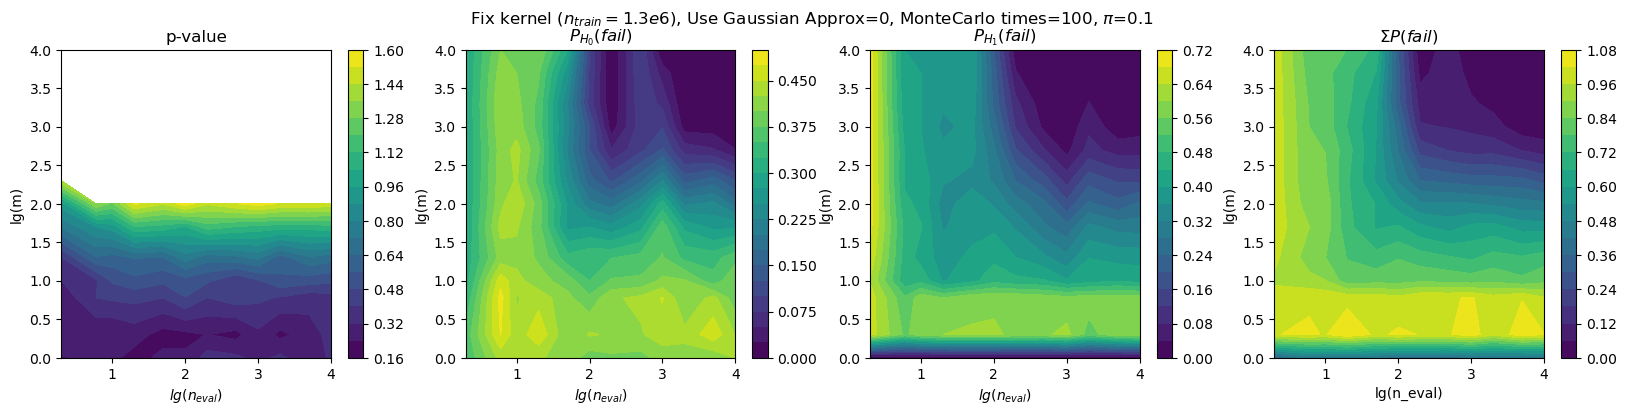

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(np.log10(n_list), np.log10(m_list), Pval_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('p-value')

plt.subplot(1,4,2)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_0}(fail)$')

plt.subplot(1,4,3)
plt.contourf(np.log10(n_list), np.log10(m_list), Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_1}(fail)$')

plt.subplot(1,4,4)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T+Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('lg(n_eval)')
plt.ylabel('lg(m)')
plt.title('$\Sigma P(fail)$')

plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', MonteCarlo times='+str(MonteCarlo_in_class)+', $\pi$='+str(pi))

In [ ]:
# np.save('type12.npy', type12)

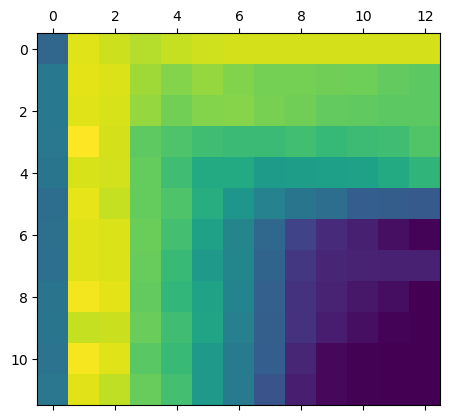

In [ ]:
type12 = Type1_mat+Type2_mat
plt.matshow(type12)

# 固定pi=0.9, Gaussian

In [ ]:
pi= 0.9
n_list = np.array([2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
Pval_mat = np.zeros((len(n_list), len(m_list)))
Type1_mat = np.zeros((len(n_list), len(m_list)))
Type2_mat = np.zeros((len(n_list), len(m_list)))
Use_Gaussian = 1
MonteCarlo_in_class = 100
repeat_sample_n_eval = 100
for r in range(repeat_sample_n_eval):
    for i in trange(len(n_list)):
        with torch.no_grad():
            torch.cuda.empty_cache()
            n_eval = n_list[i]
            X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo=10)
            My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
            for j in range(len(m_list)):
                m = m_list[j]
                Pval_mat[i,j] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type1_mat[i,j] += My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type2_mat[i,j] += My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            del My_class, X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy
            gc.collect()
    clear_output()
Pval_mat /= repeat_sample_n_eval
Type1_mat /= repeat_sample_n_eval
Type2_mat /= repeat_sample_n_eval
np.save('Pval_mat_09.npy', Pval_mat)
np.save('Type1_mat_09.npy', Type1_mat)
np.save('Type2_mat_09.npy', Type2_mat)



Text(0.5, 0.98, 'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx=1, $\\pi$=0.9')

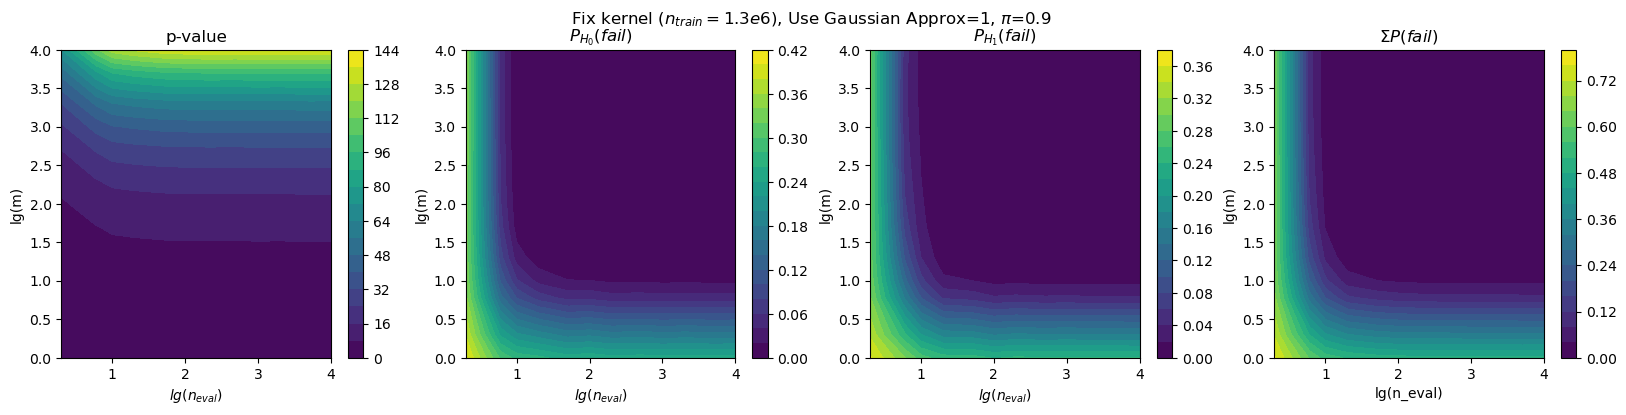

In [ ]:
levels = 20

plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(np.log10(n_list), np.log10(m_list), Pval_mat.T, levels=levels)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('p-value')

plt.subplot(1,4,2)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T, levels=levels)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_0}(fail)$')

plt.subplot(1,4,3)
plt.contourf(np.log10(n_list), np.log10(m_list), Type2_mat.T, levels=levels)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_1}(fail)$')

plt.subplot(1,4,4)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T+Type2_mat.T, levels=levels)
plt.colorbar()
plt.xlabel('lg(n_eval)')
plt.ylabel('lg(m)')
plt.title('$\Sigma P(fail)$')

plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))

# 固定pi=0.9, 不Gaussian

In [ ]:
pi= 0.9
n_list = np.array([2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000])
m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000])
Pval_mat = np.zeros((len(n_list), len(m_list)))
Type1_mat = np.zeros((len(n_list), len(m_list)))
Type2_mat = np.zeros((len(n_list), len(m_list)))
Use_Gaussian = 0
MonteCarlo_in_class = 200
repeat_sample_n_eval = 10
for r in range(repeat_sample_n_eval):
    for i in trange(len(n_list)):
        with torch.no_grad():
            torch.cuda.empty_cache()
            n_eval = n_list[i]
            X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo=10)
            My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
            for j in range(len(m_list)):
                m = m_list[j]
                Pval_mat[i,j] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type1_mat[i,j] += My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
                Type2_mat[i,j] += My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            del My_class, X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy
            gc.collect()
    clear_output()
Pval_mat /= repeat_sample_n_eval
Type1_mat /= repeat_sample_n_eval
Type2_mat /= repeat_sample_n_eval


Text(0.5, 0.98, 'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx=0, MonteCarlo times=200, $\\pi$=0.9')

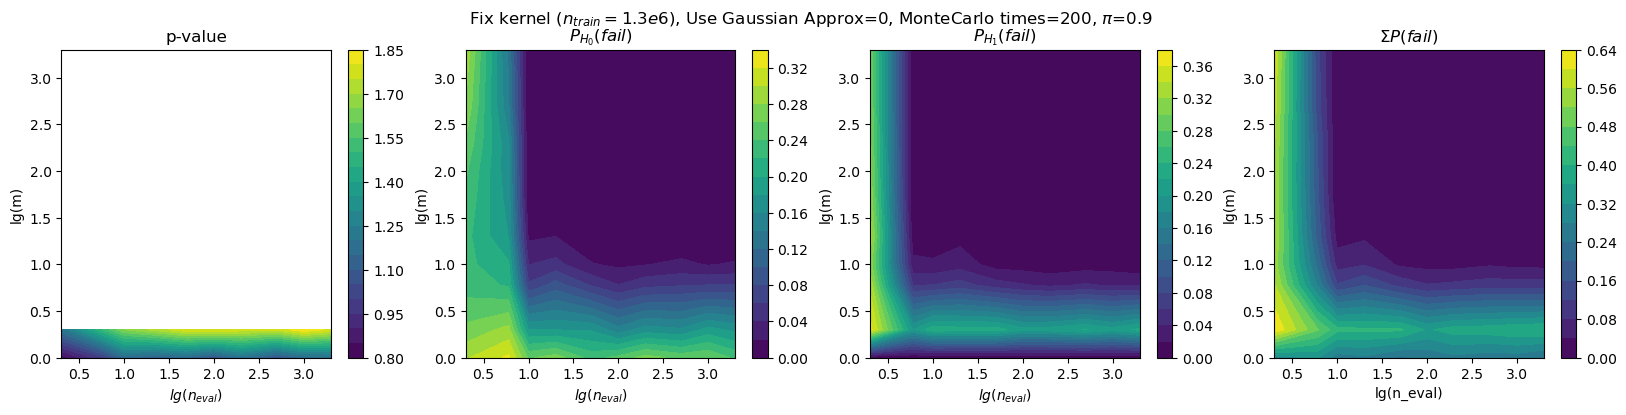

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(np.log10(n_list), np.log10(m_list), Pval_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('p-value')

plt.subplot(1,4,2)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_0}(fail)$')

plt.subplot(1,4,3)
plt.contourf(np.log10(n_list), np.log10(m_list), Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('$P_{H_1}(fail)$')

plt.subplot(1,4,4)
plt.contourf(np.log10(n_list), np.log10(m_list), Type1_mat.T+Type2_mat.T, levels=20)
plt.colorbar()
plt.xlabel('lg(n_eval)')
plt.ylabel('lg(m)')
plt.title('$\Sigma P(fail)$')

plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', MonteCarlo times='+str(MonteCarlo_in_class)+', $\pi$='+str(pi))

# 画pi-m, 固定n, 画p等高线, Gaussian

In [ ]:
n_evl = 1000
X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo=10)
My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)

m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500])
pi_list = np.array([0.01, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
Pval_mat = np.zeros((len(m_list), len(pi_list)))

Use_Gaussian = True
MonteCarlo_in_class = 200
repeat_sample_n_eval = 10
for r in range(repeat_sample_n_eval):
    for i in trange(len(m_list)):
        for j in range(len(pi_list)):
            torch.cuda.empty_cache()
            m = m_list[i]
            pi = pi_list[j]
            Pval_mat[i,j] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            #Type1_mat[i,j] = My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            #Type2_mat[i,j] = My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
    clear_output()
Pval_mat /= repeat_sample_n_eval

Text(0.5, 1.0, '$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian=True')

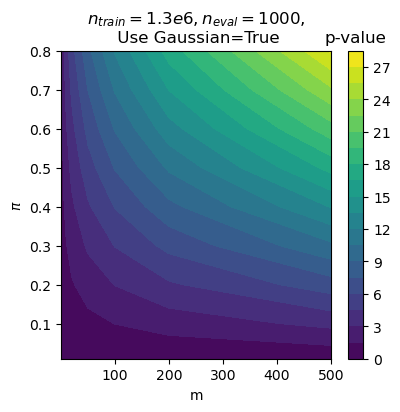

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(m_list, pi_list, Pval_mat.T, levels=20)
clb = plt.colorbar()
clb.ax.set_title('p-value')
plt.xlabel('m')
plt.ylabel('$\pi$')
plt.title('$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian='+str(Use_Gaussian))


Text(0.5, 1.0, '$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian=True')

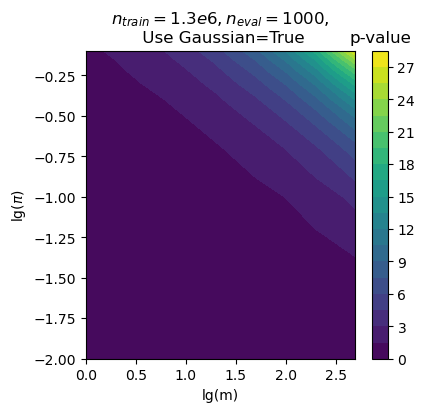

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(np.log10(m_list), np.log10(pi_list), Pval_mat.T, levels=20)
clb = plt.colorbar()
clb.ax.set_title('p-value')
plt.xlabel('lg(m)')
plt.ylabel('lg($\pi$)')
plt.title('$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian='+str(Use_Gaussian))


# 画pi-m, 固定n, 画p等高线，不Gaussian

In [ ]:
n_evl = 1000
X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo=10)
My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)

m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 400, 800])
pi_list = np.array([0.01, 0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5])
Pval_mat = np.zeros((len(m_list), len(pi_list)))

Use_Gaussian = False
MonteCarlo_in_class = 1000
repeat_sample_n_eval = 10
for r in range(repeat_sample_n_eval):
    for i in trange(len(m_list)):
        for j in range(len(pi_list)):
            torch.cuda.empty_cache()
            m = m_list[i]
            pi = pi_list[j]
            Pval_mat[i,j] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            #Type1_mat[i,j] = My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
            #Type2_mat[i,j] = My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=MonteCarlo_in_class)
    clear_output()
Pval_mat /= repeat_sample_n_eval


Text(0.5, 1.0, '$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian=False\n MonteCarlo=1000')

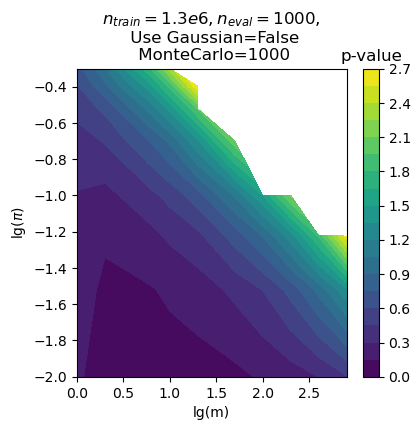

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.contourf(np.log10(m_list), np.log10(pi_list), Pval_mat.T, levels=20)
clb = plt.colorbar()
clb.ax.set_title('p-value')
plt.xlabel('lg(m)')
plt.ylabel('lg($\pi$)')
plt.title('$n_{train}=1.3e6, n_{eval}=1000$,\n Use Gaussian='+str(Use_Gaussian)+'\n MonteCarlo='+str(MonteCarlo_in_class))


In [ ]:
T_mix_MonteCarlo_list

NameError: name 'T_mix_MonteCarlo_list' is not defined

In [ ]:
a = 0.8
b = 0.8
p = scipy.stats.binom.cdf(100*a+1000*(1-b), 1100, 1-b)
scipy.stats.norm.ppf(p)

4.357556486020054